In [2]:
import os, re, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pathlib import Path
from scipy.stats import pearsonr

all_hosps = "73-264-420-243-338-443-199-458-300-188-252-167-122"
hosp_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167, 122]

model = "CatBoostClassifier"
log_dir = Path(f"../../yaib_logs/eicu/Mortality24/{model}/")
data_dir = Path("../../YAIB-cohorts/data/mortality24/eicu")

In [2]:
df = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

# patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
# patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

# df = df.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
# df = df.rename(columns={'hospitalid': 'hosp_id'})

# # add outcome data
df_outc = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/outc.parquet', engine='pyarrow')

df = df.merge(df_outc, on='stay_id')


In [3]:
df

,stay_id,age,sex,height,weight,ethnic,hospitalid,label
0,141179,52.0,Female,162.6,NaN,white,60,0
1,141194,68.0,Male,180.3,73.9,white,73,0
2,141203,77.0,Female,160.0,70.2,white,66,0
3,141233,81.0,Female,165.1,61.7,white,73,0
4,141244,59.0,Male,180.3,92.3,white,73,0
...,...,...,...,...,...,...,...,...
113376,3353201,66.0,Female,157.5,71.5,white,458,0
113377,3353213,51.0,Female,160.0,54.4,white,458,0
113378,3353216,50.0,Female,165.1,55.4,black,458,0
113379,3353226,79.0,Female,121.9,58.4,black,458,1


In [10]:
col_sums = df.loc[:, df.columns.str.startswith('hosp_')].sum(numeric_only=True)
print(col_sums)

total = col_sums.sum()
print(total)

hosp_73     4320
hosp_122    2031
hosp_167    2107
hosp_188    2299
hosp_199    2529
hosp_243    2812
hosp_252    2210
hosp_264    3745
hosp_300    2370
hosp_338    2762
hosp_420    3425
hosp_443    2580
hosp_458    2456
dtype: int64
35646


In [11]:
hosp_cols = df.columns[df.columns.str.startswith('hosp_')]
label_rates = {}
for col in hosp_cols:
    hosp_mask = df[col] == 1
    label_rates[col] = df.loc[hosp_mask, 'label'].mean() if hosp_mask.any() else float('nan')

label_rates = pd.Series(label_rates)#.sort_values(ascending=False)
print(label_rates)


hosp_73     0.017130
hosp_122    0.071393
hosp_167    0.083056
hosp_188    0.066116
hosp_199    0.062080
hosp_243    0.025605
hosp_252    0.090498
hosp_264    0.044860
hosp_300    0.060759
hosp_338    0.054308
hosp_420    0.088175
hosp_443    0.073256
hosp_458    0.095277
dtype: float64


In [34]:
# add / remove one-hot hospital id columns
ONE_HOT_ENCODE = False

# 1. load static features and hospital mapping
sta = pd.read_parquet(data_dir / "sta.parquet")
patient_hosp = pd.read_csv(data_dir / "patient_hospital.csv")  # get patientunitstayid, hospitalid

patient_hosp = patient_hosp.rename(columns={"patientunitstayid": "stay_id"})
sta_with_hosp = sta.merge(patient_hosp[["stay_id", "hospitalid"]], on="stay_id", how="left")

# 2. check if data aligns ONE_HOT_ENCODE
one_hot_cols = [f"hosp_{hid}" for hid in hosp_ids]
one_hot_encoded = all(col in sta.columns for col in one_hot_cols)

if one_hot_encoded == ONE_HOT_ENCODE:
    print("File matches desired specification. \"sta.parquet\" not modified.")
elif ONE_HOT_ENCODE:
    # 3. one-hot encode hospital id
    hosp_dummies = pd.get_dummies(sta_with_hosp["hospitalid"], prefix="hosp", dtype=int)
    hosp_dummies = hosp_dummies[[col for col in one_hot_cols if col in hosp_dummies.columns]]

    # 4. attach to static dataframe and drop raw hospital column
    sta_augmented = pd.concat([sta_with_hosp.drop(columns=["hospitalid"]), hosp_dummies], axis=1)

    # 5. save back to parquet (backup first if desired)
    backup_path = data_dir / "sta_original_backup.parquet"
    if not backup_path.exists():
        sta.to_parquet(backup_path, index=False)

    sta_augmented.to_parquet(data_dir / "sta.parquet", index=False)
    print("Updated sta.parquet with hospital one-hot features.")
elif not ONE_HOT_ENCODE:
    sta_augmented = sta_with_hosp.drop(columns=one_hot_cols)

    backup_path = data_dir / "sta_original_backup.parquet"
    if not backup_path.exists():
        sta.to_parquet(backup_path, index=False)

    sta_augmented.to_parquet(data_dir / "sta.parquet", index=False)
    print("Removed hospital one-hot features from sta.parquet.")


File matches desired specification. "sta.parquet" not modified.


## Read Results

Want:
- Accuracy
- AUC
- R2

For each test hospital:
- With hosp_id
- Without hosp_id
- Trained on hospital data only (base)

In [18]:
# get base results
avg_dict = {} 
std_dict = {} 
ci_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{hos}-test{hos}"
    exp_dir = os.path.join(log_dir, dir_str)
    files = os.listdir(exp_dir)
    files.sort()
    datetime = files[-1]
    f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
    result_dict = json.load(f)
    for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
        key_results = result_dict[keyword]
        for key in key_results.keys(): 
            if key not in key_dict:
                key_dict[key] = {}
            key_dict[key][hos] = key_results[key]
    ci = result_dict['CI_0.95']
    for key in ci.keys(): 
        if key not in ci_dict:
            ci_dict[key] = {}
        ci_dict[key][hos] = (ci[key][0], ci[key][1])


# np.savez(f"../results/base/{model}-avg.npz", **avg_dict)
# np.savez(f"../results/base/{model}-std.npz", **std_dict)
# np.savez(f"../results/base/{model}-ci.npz", **ci_dict)

In [36]:
# get results trained on all hospital data combined (no hospital id feature)
all_avg_dict = {} 
all_std_dict = {} 
all_ci_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(log_dir, dir_str)
    files = os.listdir(exp_dir)
    files.sort()
    datetime = files[-2]
    f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
    result_dict = json.load(f)
    for keyword, key_dict in zip(['avg', 'std'], [all_avg_dict, all_std_dict]): 
        key_results = result_dict[keyword]
        for key in key_results.keys(): 
            if key not in key_dict:
                key_dict[key] = {}
            key_dict[key][hos] = key_results[key]
    ci = result_dict['CI_0.95']
    for key in ci.keys(): 
        if key not in all_ci_dict:
            all_ci_dict[key] = {}
        all_ci_dict[key][hos] = (ci[key][0], ci[key][1])


# np.savez(f"../results/all_hosps/{model}-avg.npz", **all_avg_dict)
# np.savez(f"../results/all_hosps/{model}-std.npz", **all_std_dict)
# np.savez(f"../results/all_hosps/{model}-ci.npz", **all_ci_dict)

In [20]:
# get results trained on all hospital data combined (with hospital id feature)
id_all_avg_dict = {} 
id_all_std_dict = {} 
id_all_ci_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(log_dir, dir_str)
    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg', 'std'], [id_all_avg_dict, id_all_std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict:
                    key_dict[key] = {}
                key_dict[key][hos] = key_results[key]
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in id_all_ci_dict:
                id_all_ci_dict[key] = {}
            id_all_ci_dict[key][hos] = (ci[key][0], ci[key][1])
    except:
        print(exp_dir)


# np.savez(f"../results/all_hosps_id/{model}-avg.npz", **id_all_avg_dict)
# np.savez(f"../results/all_hosps_id/{model}-std.npz", **id_all_std_dict)
# np.savez(f"../results/all_hosps_id/{model}-ci.npz", **id_all_ci_dict)

../../yaib_logs/eicu/Mortality24/LogisticRegression/train73-264-420-243-338-443-199-458-300-188-252-167-122-test458_id
../../yaib_logs/eicu/Mortality24/LogisticRegression/train73-264-420-243-338-443-199-458-300-188-252-167-122-test300_id
../../yaib_logs/eicu/Mortality24/LogisticRegression/train73-264-420-243-338-443-199-458-300-188-252-167-122-test188_id
../../yaib_logs/eicu/Mortality24/LogisticRegression/train73-264-420-243-338-443-199-458-300-188-252-167-122-test252_id
../../yaib_logs/eicu/Mortality24/LogisticRegression/train73-264-420-243-338-443-199-458-300-188-252-167-122-test167_id
../../yaib_logs/eicu/Mortality24/LogisticRegression/train73-264-420-243-338-443-199-458-300-188-252-167-122-test122_id


In [31]:
rbf_dir = Path(f"../../yaib_logs/eicu/Mortality24/{model}RBF/")

# get results trained on all hospital data combined (with hospital id feature)
rbf_id_all_avg_dict = {} 
rbf_id_all_std_dict = {} 
rbf_id_all_ci_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(rbf_dir, dir_str)
    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg', 'std'], [rbf_id_all_avg_dict, rbf_id_all_std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict:
                    key_dict[key] = {}
                key_dict[key][hos] = key_results[key]
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in rbf_id_all_ci_dict:
                rbf_id_all_ci_dict[key] = {}
            rbf_id_all_ci_dict[key][hos] = (ci[key][0], ci[key][1])
    except:
        print(exp_dir)


# np.savez(f"../results/all_hosps_id/{model}-avg.npz", **id_all_avg_dict)
# np.savez(f"../results/all_hosps_id/{model}-std.npz", **id_all_std_dict)
# np.savez(f"../results/all_hosps_id/{model}-ci.npz", **id_all_ci_dict)

In [ ]:
# get results trained on all hospital data combined (with hospital id feature)
id_all_avg_dict = {} 
id_all_std_dict = {} 
id_all_ci_dict = {} 

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(log_dir, dir_str)
    try:
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg', 'std'], [id_all_avg_dict, id_all_std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict:
                    key_dict[key] = {}
                key_dict[key][hos] = key_results[key]
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in id_all_ci_dict:
                id_all_ci_dict[key] = {}
            id_all_ci_dict[key][hos] = (ci[key][0], ci[key][1])
    except:
        print(exp_dir)


# np.savez(f"../results/all_hosps_id/{model}-avg.npz", **id_all_avg_dict)
# np.savez(f"../results/all_hosps_id/{model}-std.npz", **id_all_std_dict)
# np.savez(f"../results/all_hosps_id/{model}-ci.npz", **id_all_ci_dict)

FileNotFoundError: [Errno 2] No such file or directory: '../../yaib_logs/eicu/Mortality24/LogisticRegression/train73-264-420-243-338-443-199-458-300-188-252-167-122-test458_id'

KeyError: 'AUC_TEST'

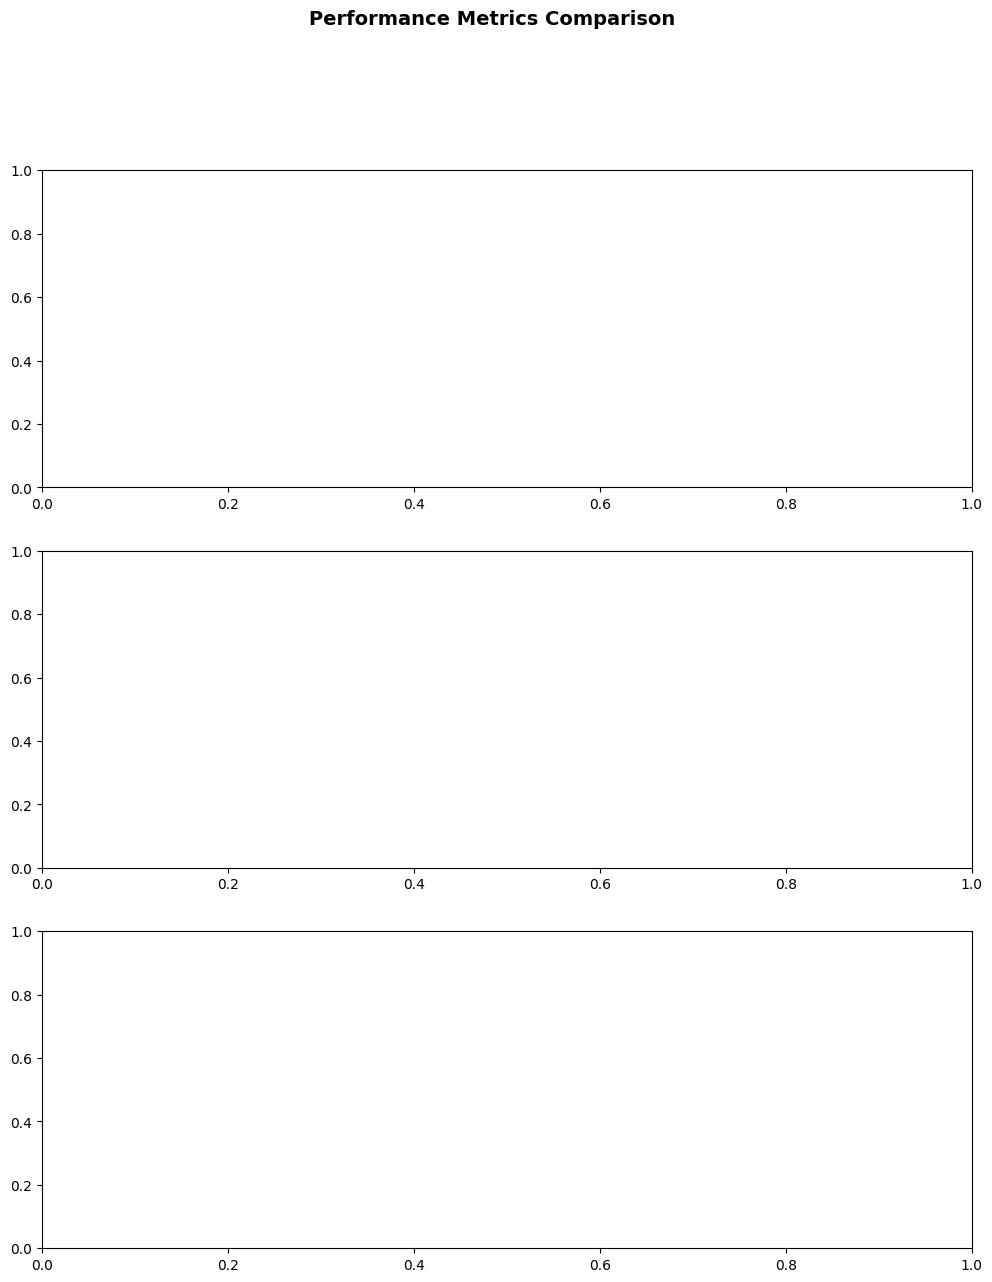

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Your dictionaries (replace with actual data)
# avg_dict = {...}
# all_avg_dict = {...}
# id_all_avg_dict = {...}

# Metrics to compare
metrics = ["AUC_TEST", "ACC_TEST", "R2"]
dict_names = ["One-to-one", "All hospitals (no id)", "All hospitals (w/ id)"]
dicts = [avg_dict, all_avg_dict, id_all_avg_dict]

# ==================== PLOT 1: BAR CHARTS ====================
fig1, axes = plt.subplots(3, 1, figsize=(12, 14))
fig1.suptitle('Performance Metrics Comparison', fontsize=14, fontweight='bold', y=0.995)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Extract sub-keys and values
    sub_keys = list(dicts[0][metric].keys())
    
    # Prepare data for plotting
    data = {dict_name: [] for dict_name in dict_names}
    for dict_name, d in zip(dict_names, dicts):
        data[dict_name] = [d[metric][key] for key in sub_keys]
    
    # Create bar plot
    x = np.arange(len(sub_keys))
    width = 0.25
    
    for i, dict_name in enumerate(dict_names):
        offset = (i - 1) * width
        ax.bar(x + offset, data[dict_name], width, label=dict_name, alpha=0.8)
    
    ax.set_xlabel('Hospital', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(sub_keys, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== PLOT 2: TABLES ====================
fig2, axes = plt.subplots(3, 1, figsize=(8, 14))
fig2.suptitle('Performance Metrics Tables', fontsize=14, fontweight='bold')
plt.subplots_adjust(hspace=0.5)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.axis('tight')
    ax.axis('off')
    
    # Extract sub-keys
    sub_keys = list(dicts[0][metric].keys())
    
    # Prepare table data
    table_data = []
    table_data.append(['Hospital'] + dict_names)  # Header
    for key in sub_keys:
        row = [key]
        for d in dicts:
            row.append(f"{d[metric][key]:.4f}")
        table_data.append(row)
    # Identify which prediction setup hits the single highest value
    best_col_idx = 1
    best_col_value = float('-inf')
    for col_idx, d in enumerate(dicts, start=1):
        col_max = max(d[metric].values())
        if col_max > best_col_value:
            best_col_value = col_max
            best_col_idx = col_idx
    
    # Create table
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.3] + [0.23]*3)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header row
    for i in range(len(dict_names) + 1):
        cell = table[(0, i)]
        cell.set_facecolor('#4CAF50')
        cell.set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(sub_keys) + 1):
        for j in range(len(dict_names) + 1):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#f0f0f0')
    # Bold the column that owns the highest metric value (skip the Hospital column)
    for row_idx in range(len(sub_keys) + 1):
        cell = table[(row_idx, best_col_idx)]
        cell.get_text().set_fontweight('bold')
    
    #ax.set_title(f'{metric} Values Table', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [ ]:
# Metrics to compare
metrics = ["AUC_TEST", "ACC_TEST", "R2"]
dict_names = ["One-to-one", "All hospitals (no id)", "All hospitals (w/ id)"]
dicts = [avg_dict, all_avg_dict, id_all_avg_dict]

# ==================== PLOT 1: BAR CHARTS ====================
fig1, axes = plt.subplots(3, 1, figsize=(12, 14))
fig1.suptitle('Performance Metrics Comparison', fontsize=14, fontweight='bold', y=0.995)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Extract sub-keys and values
    sub_keys = list(dicts[0][metric].keys())
    
    # Prepare data for plotting
    data = {dict_name: [] for dict_name in dict_names}
    for dict_name, d in zip(dict_names, dicts):
        data[dict_name] = [d[metric][key] for key in sub_keys]
    
    # Create bar plot
    x = np.arange(len(sub_keys))
    width = 0.25
    
    for i, dict_name in enumerate(dict_names):
        offset = (i - 1) * width
        ax.bar(x + offset, data[dict_name], width, label=dict_name, alpha=0.8)
    
    ax.set_xlabel('Hospital', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(sub_keys, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ---- Zoom in for AUC and ACC to better show differences ----
    if metric in ("AUC_TEST", "ACC_TEST"):
        all_vals = np.array(sum([v for v in data.values()], []), dtype=float)
        vmin, vmax = float(np.min(all_vals)), float(np.max(all_vals))
        if vmin != vmax:
            margin = max(0.01, 0.1 * (vmax - vmin))  # at least a tiny margin
            ax.set_ylim(vmin - margin, vmax + margin)
        else:
            # All equal: set a tiny window around the value so bars are visible
            ax.set_ylim(vmin - 0.01, vmax + 0.01)

plt.tight_layout()
plt.show()


NameError: name 'avg_dict' is not defined

KeyError: 'AUC_TEST'

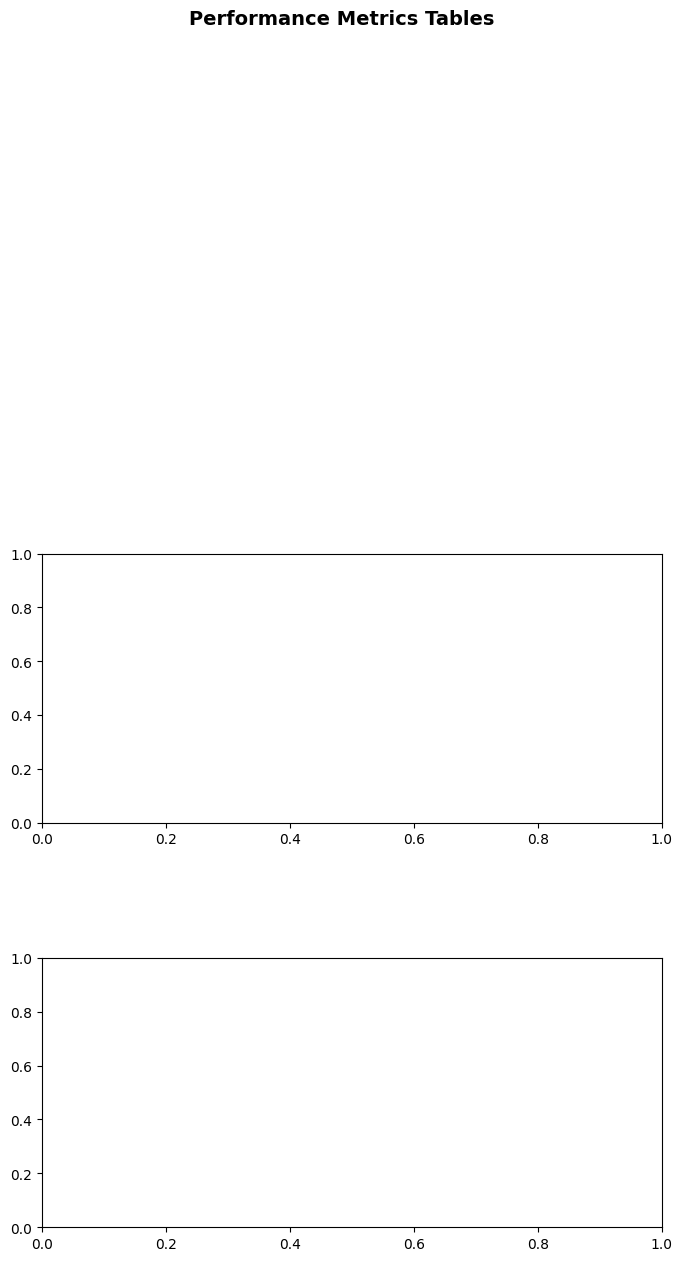

In [17]:
# ==================== PLOT 2: TABLES ====================
fig2, axes = plt.subplots(3, 1, figsize=(8, 14))
fig2.suptitle('Performance Metrics Tables', fontsize=14, fontweight='bold')
plt.subplots_adjust(hspace=0.5)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.axis('tight')
    ax.axis('off')
    
    # Extract sub-keys
    sub_keys = list(dicts[0][metric].keys())
    
    # Prepare table data
    header = ['Hospital'] + dict_names
    table_data = [header]
    for key in sub_keys:
        row = [key]
        for d in dicts:
            row.append(f"{d[metric][key]:.4f}")
        table_data.append(row)
    
    # Create table
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.3] + [0.23]*3)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # ---------- Styling ----------
    # Style header row
    for i in range(len(dict_names) + 1):
        cell = table[(0, i)]
        cell.set_facecolor('#4CAF50')
        cell.set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(sub_keys) + 1):  # data rows only
        for j in range(len(dict_names) + 1):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#f0f0f0')

    # ---------- Bold the highest value per row (skip Hospital column) ----------
    # Row indices in the table: 1..len(sub_keys)
    # Column indices for metric values: 1..len(dict_names)
    for row_idx, key in enumerate(sub_keys, start=1):
        # numeric values for this hospital across the three setups
        vals = [dicts[col_idx][metric][key] for col_idx in range(len(dicts))]
        max_val = max(vals)
        # Bold all maxima (handles ties)
        for col_idx, v in enumerate(vals, start=1):
            if np.isclose(v, max_val):
                table[(row_idx, col_idx)].get_text().set_fontweight('bold')

plt.tight_layout()
plt.show()

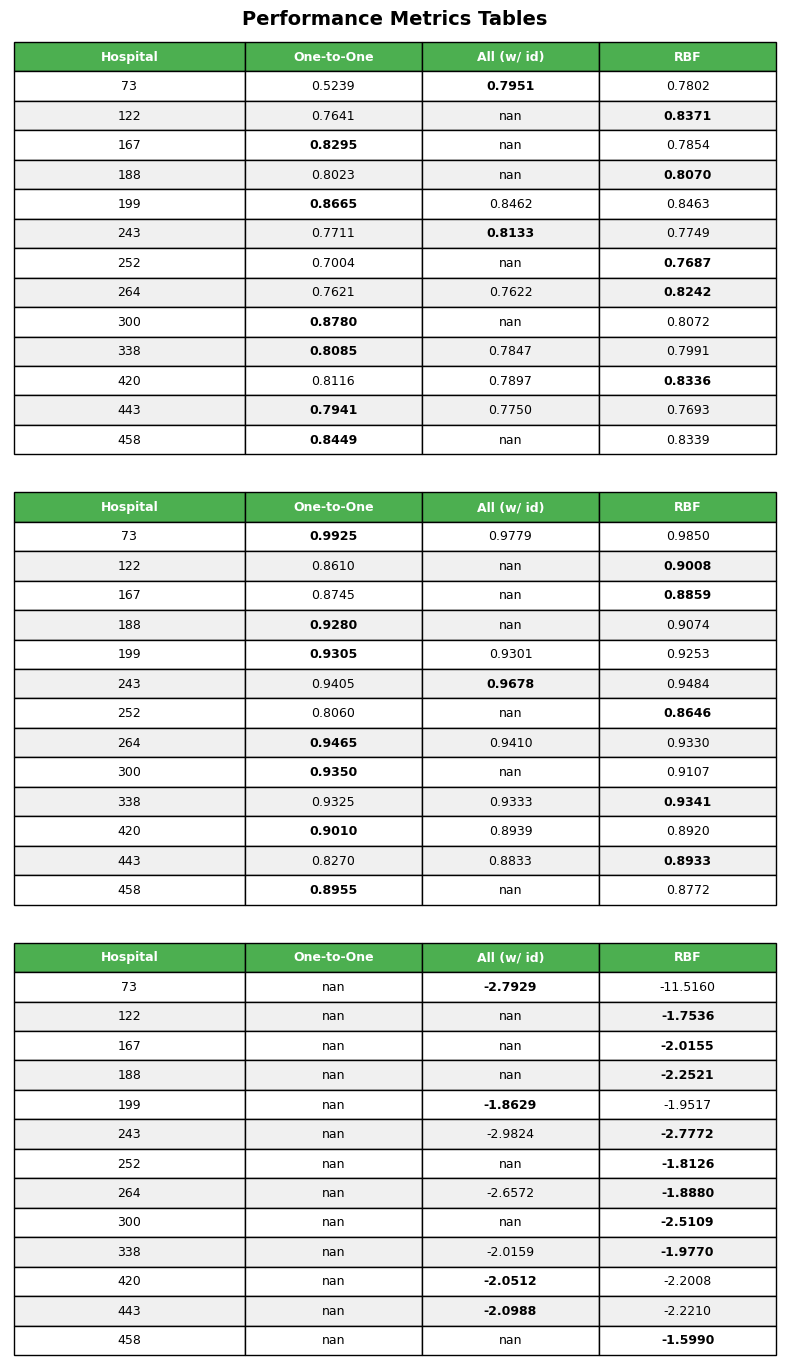

In [33]:
import numpy as np

metrics = ["AUC_TEST", "ACC_TEST", "R2"]
dict_names = ["One-to-One", "All (w/ id)", "RBF"]
dicts = [avg_dict, id_all_avg_dict, rbf_id_all_avg_dict]

# ==================== PLOT 2: TABLES ====================
fig2, axes = plt.subplots(3, 1, figsize=(8, 14))
fig2.suptitle('Performance Metrics Tables', fontsize=14, fontweight='bold')
plt.subplots_adjust(hspace=0.5)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.axis('tight')
    ax.axis('off')
    
    # Collect all unique sub-keys across all dicts for this metric
    sub_keys = set()
    for d in dicts:
        if metric in d and isinstance(d[metric], dict):
            sub_keys.update(d[metric].keys())
    sub_keys = sorted(sub_keys)  # Sort for consistent ordering
    
    # Prepare table data
    header = ['Hospital'] + dict_names
    table_data = [header]
    for key in sub_keys:
        row = [key]
        for d in dicts:
            # Check if metric exists in dict and if key exists in that metric
            if metric in d and isinstance(d[metric], dict) and key in d[metric]:
                row.append(f"{d[metric][key]:.4f}")
            else:
                row.append("nan")
        table_data.append(row)
    
    # Create table
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.3] + [0.23]*3)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # ---------- Styling ----------
    # Style header row
    for i in range(len(dict_names) + 1):
        cell = table[(0, i)]
        cell.set_facecolor('#4CAF50')
        cell.set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(sub_keys) + 1):  # data rows only
        for j in range(len(dict_names) + 1):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#f0f0f0')

    # ---------- Bold the highest value per row (skip Hospital column) ----------
    # Row indices in the table: 1..len(sub_keys)
    # Column indices for metric values: 1..len(dict_names)
    for row_idx, key in enumerate(sub_keys, start=1):
        # Collect numeric values for this hospital across the three setups
        vals = []
        for col_idx in range(len(dicts)):
            d = dicts[col_idx]
            if metric in d and isinstance(d[metric], dict) and key in d[metric]:
                vals.append(d[metric][key])
            else:
                vals.append(np.nan)
        
        # Only bold if there's at least one valid value
        if not all(np.isnan(vals)):
            max_val = np.nanmax(vals)
            # Bold all maxima (handles ties)
            for col_idx, v in enumerate(vals, start=1):
                if not np.isnan(v) and np.isclose(v, max_val):
                    table[(row_idx, col_idx)].get_text().set_fontweight('bold')

plt.tight_layout()
plt.show()

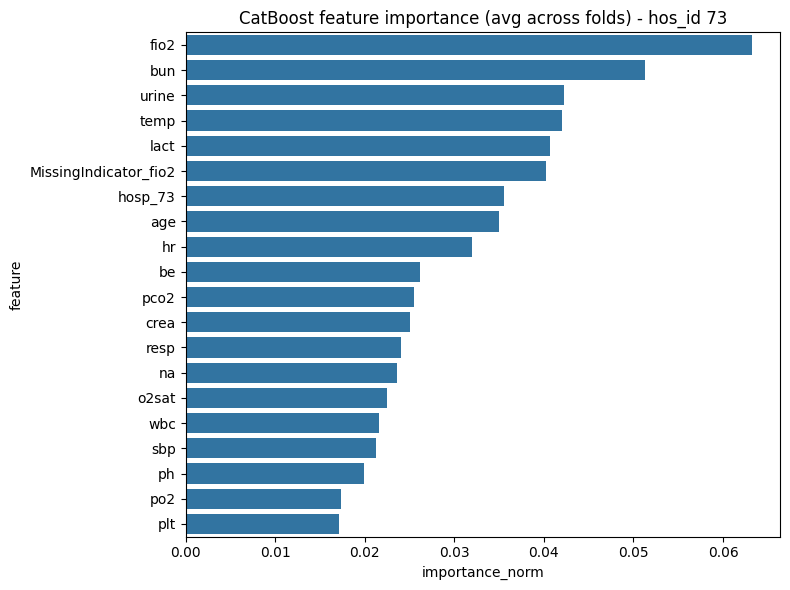

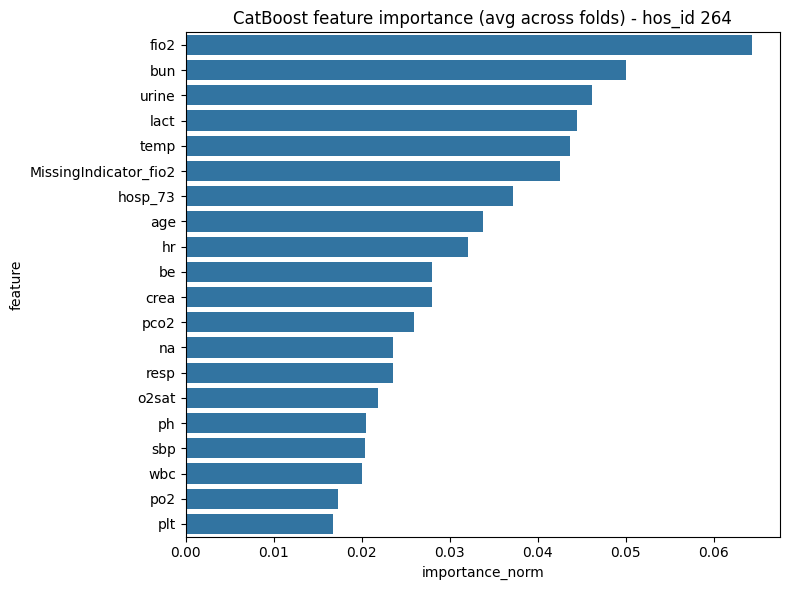

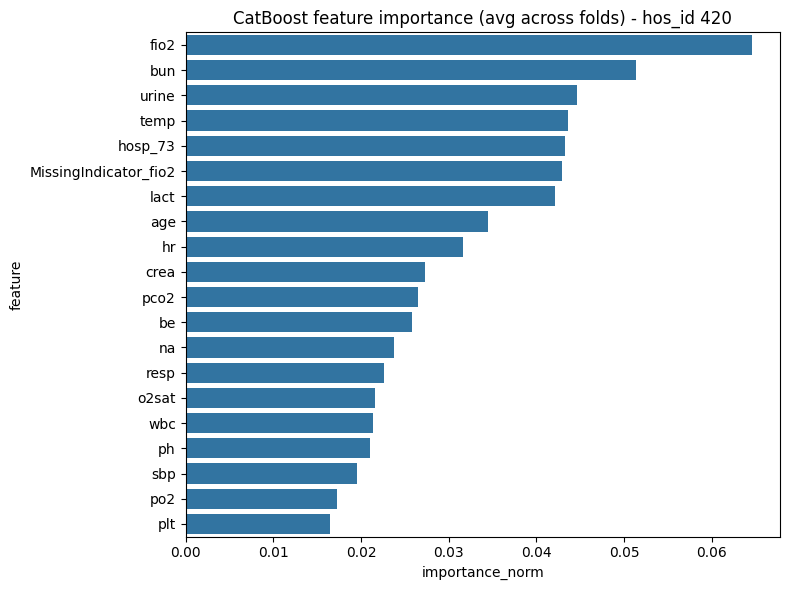

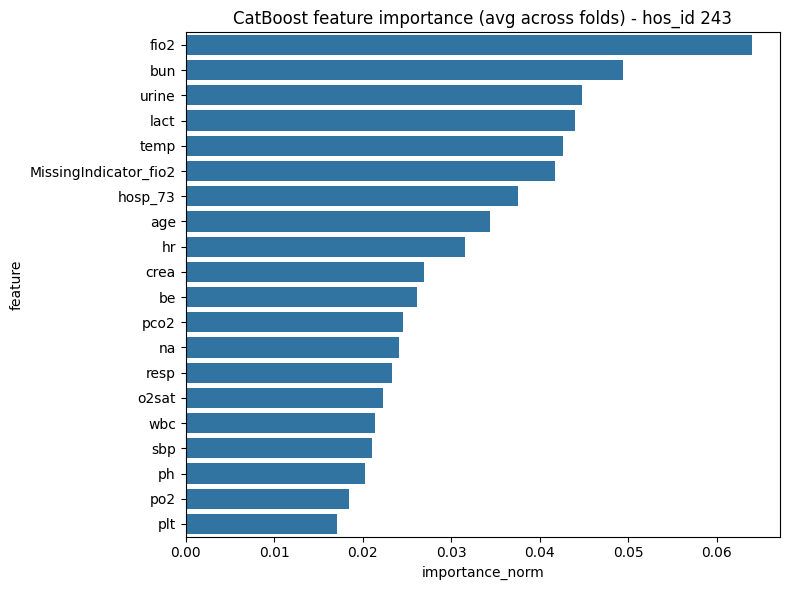

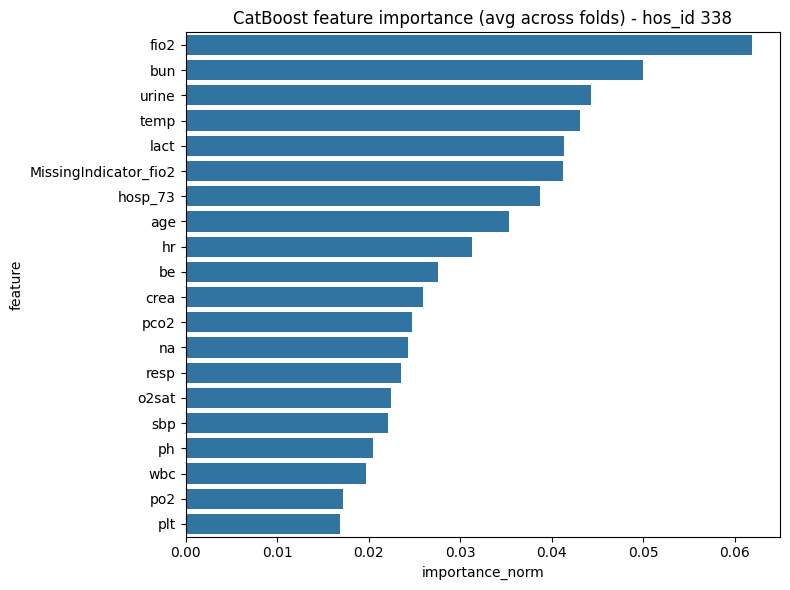

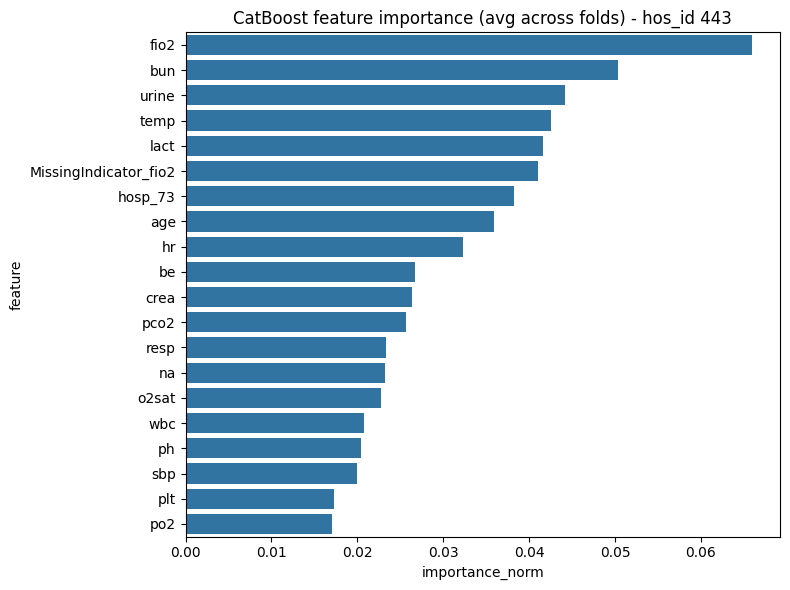

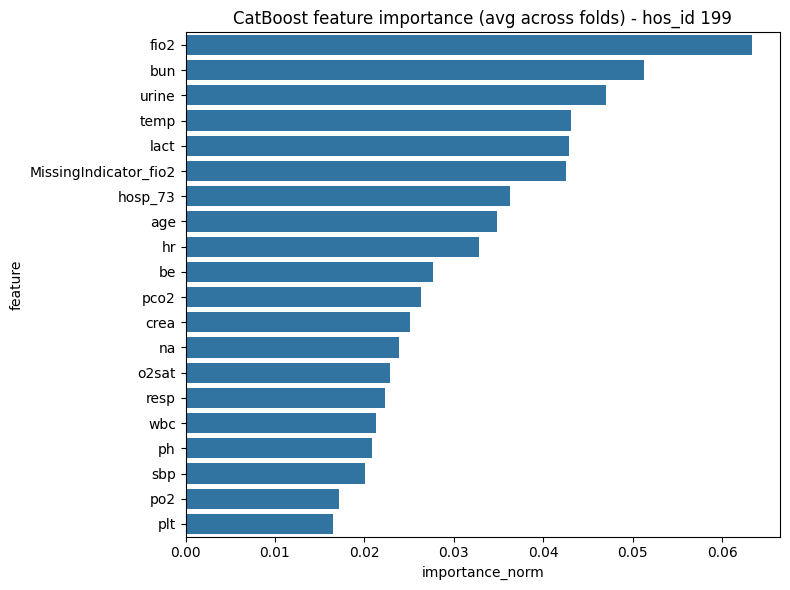

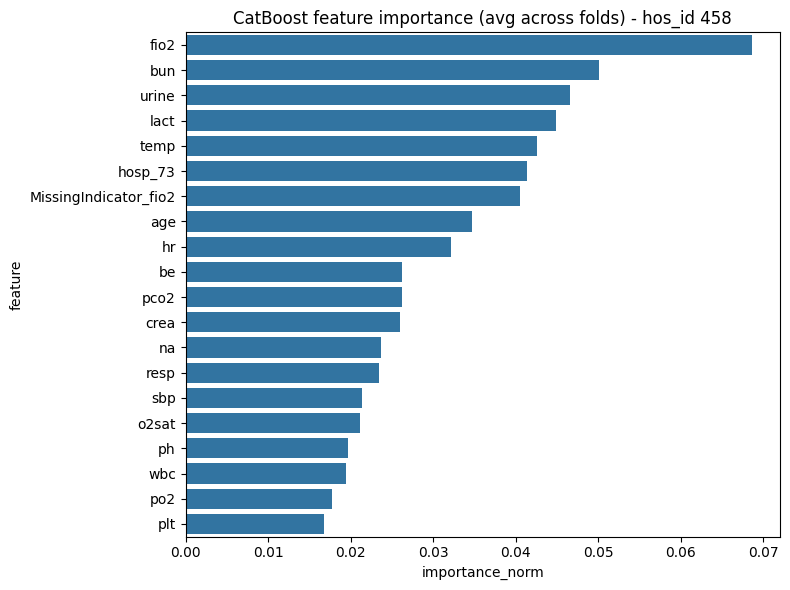

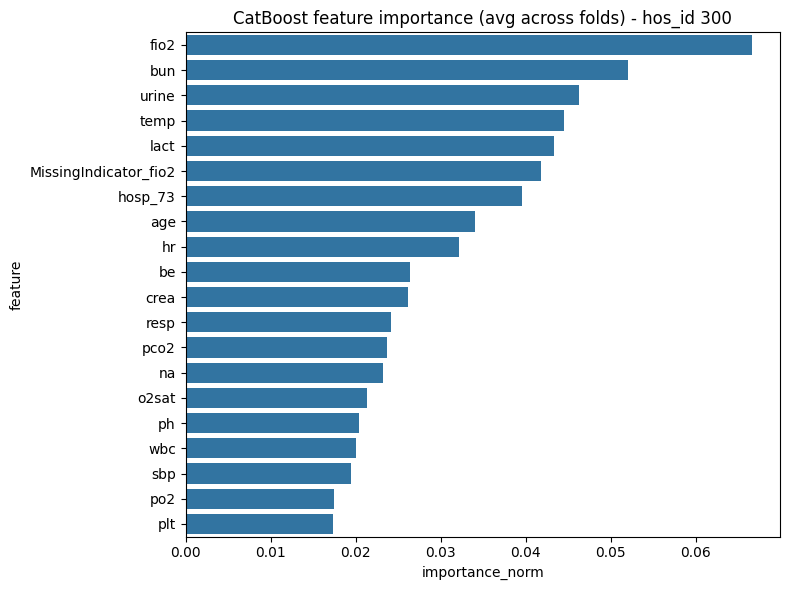

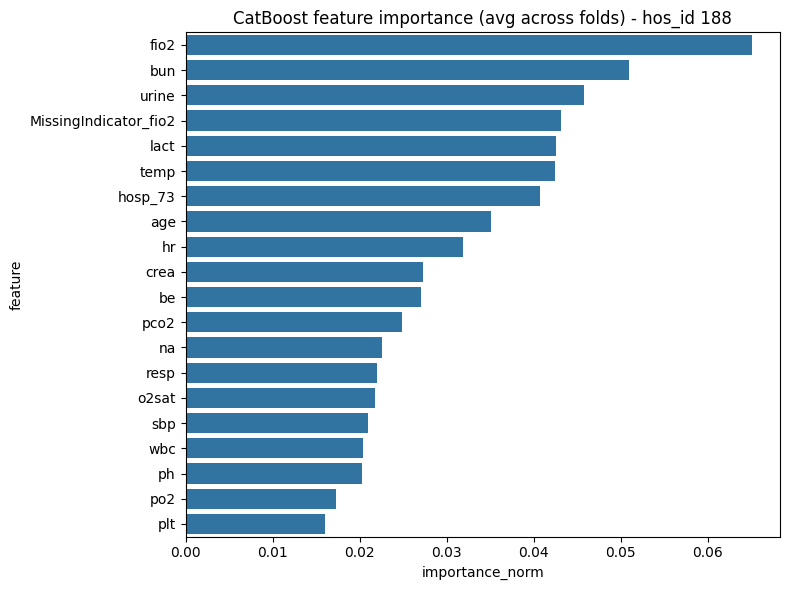

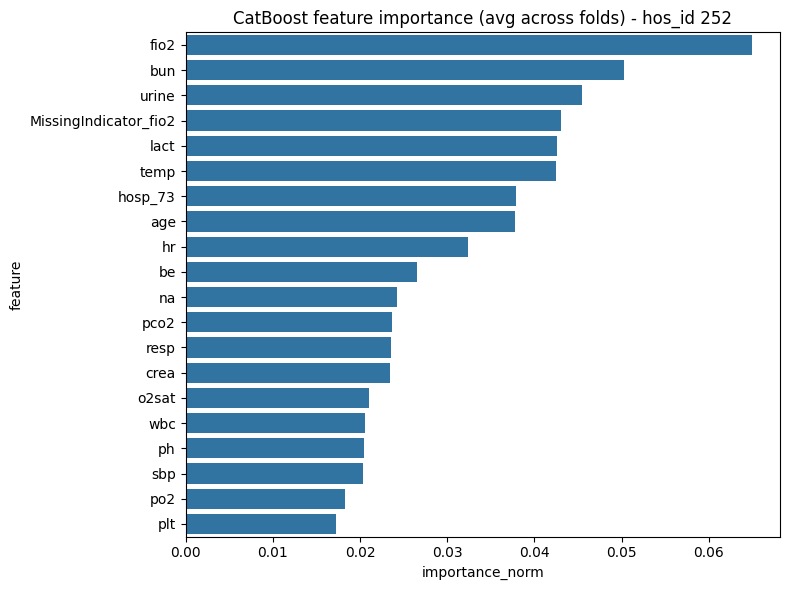

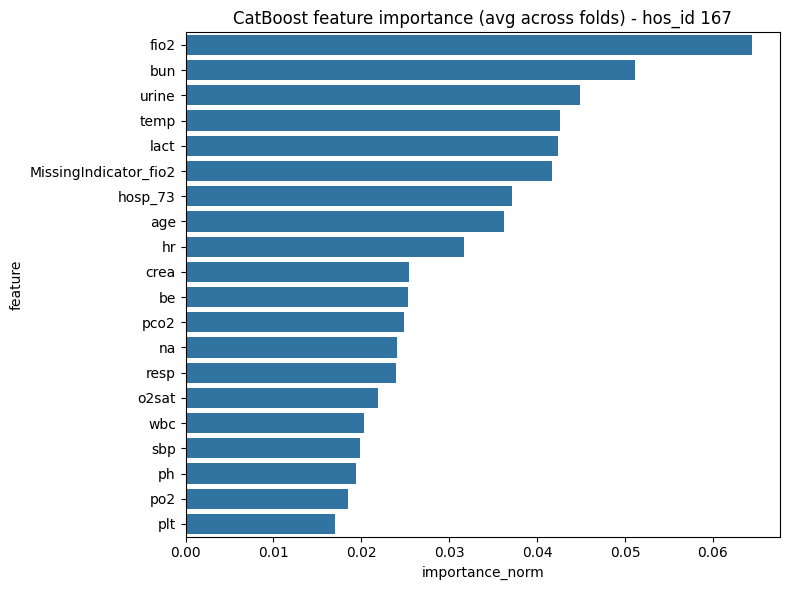

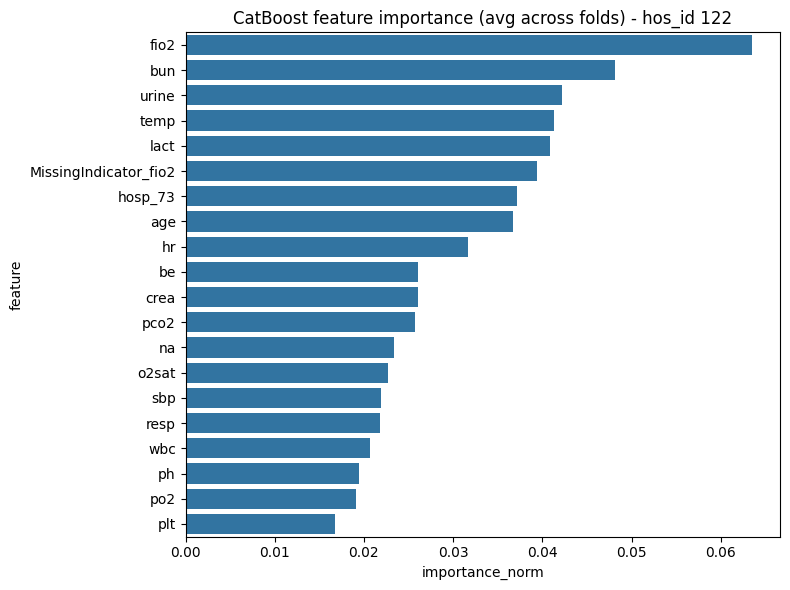

In [8]:
import json, pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


feature_importances = []
feature_interactions = []

for i, hos in enumerate(hosp_ids): 
    dir_str = f"train{all_hosps}-test{hos}_id"
    exp_dir = os.path.join(log_dir, dir_str)
    files = os.listdir(exp_dir)
    files.sort()
    datetime = files[-1]

    for rep in range(5):
        for fold in range(5):
            try:
                f = open(os.path.join(exp_dir, datetime, f"repetition_{rep}/fold_{fold}", "feature_analysis/feature_importances.json"))
            except:
                print(os.path.join(exp_dir, datetime, f"repetition_{rep}/fold_{fold}", "feature_analysis/feature_importances.json"))
                continue
            result_dict = json.load(f)
            for row in result_dict:
                feature_importances.append({"hos_id": hos, "repetition": rep, "fold": fold, "feature": row["feature"], "importance": row["importance"]})
            
fi = pd.DataFrame(feature_importances)

fi["importance_norm"] = (
    fi.groupby(["hos_id", "repetition", "fold"])["importance"]
      .transform(lambda x: x / x.sum())
)

for hos in fi["hos_id"].unique():
    fi_hos = fi[fi["hos_id"] == hos]

    top_hos = (
        fi_hos.groupby("feature")["importance_norm"]
              .mean()                     # avg over reps/folds for this hospital
              .sort_values(ascending=False)
              .head(20)
              .reset_index()
    )

    plt.figure(figsize=(8, 6))
    sns.barplot(data=top_hos, y="feature", x="importance_norm")
    plt.title(f"CatBoost feature importance (avg across folds) - hos_id {hos}")
    plt.tight_layout()
    plt.show()

In [9]:
# Assuming fi already exists and has columns:
# ["hos_id", "repetition", "fold", "feature", "importance", "importance_norm"]

# Filter to only hosp_* features
fi_hosp = fi[fi["feature"].str.startswith("hosp_")].copy()

for hos in fi_hosp["hos_id"].unique():
    fi_hos_single = fi_hosp[fi_hosp["hos_id"] == hos]

    if fi_hos_single.empty:
        print(f"\nHospital {hos}: no features starting with 'hosp_'")
        continue

    # Aggregate per feature for this hospital
    summary = (
        fi_hos_single.groupby("feature")["importance_norm"]
                     .mean()
                     .sort_values(ascending=False)
                     .reset_index()
    )
    summary["rank"] = range(1, len(summary) + 1)

    print(f"\n=== Hospital {hos} ===")
    print(summary[["rank", "feature", "importance_norm"]].to_string(index=False))



=== Hospital 73 ===
 rank  feature  importance_norm
    1  hosp_73         0.035579
    2 hosp_243         0.007712
    3 hosp_420         0.004756
    4 hosp_252         0.003969
    5 hosp_458         0.002956
    6 hosp_122         0.001083
    7 hosp_167         0.000856
    8 hosp_199         0.000660
    9 hosp_300         0.000485
   10 hosp_264         0.000479
   11 hosp_338         0.000434
   12 hosp_443         0.000430
   13 hosp_188         0.000340

=== Hospital 264 ===
 rank  feature  importance_norm
    1  hosp_73         0.037183
    2 hosp_243         0.006500
    3 hosp_420         0.004354
    4 hosp_252         0.003296
    5 hosp_458         0.003117
    6 hosp_122         0.000902
    7 hosp_167         0.000703
    8 hosp_199         0.000660
    9 hosp_443         0.000516
   10 hosp_188         0.000495
   11 hosp_264         0.000472
   12 hosp_338         0.000398
   13 hosp_300         0.000239

=== Hospital 420 ===
 rank  feature  importance_norm
    1  

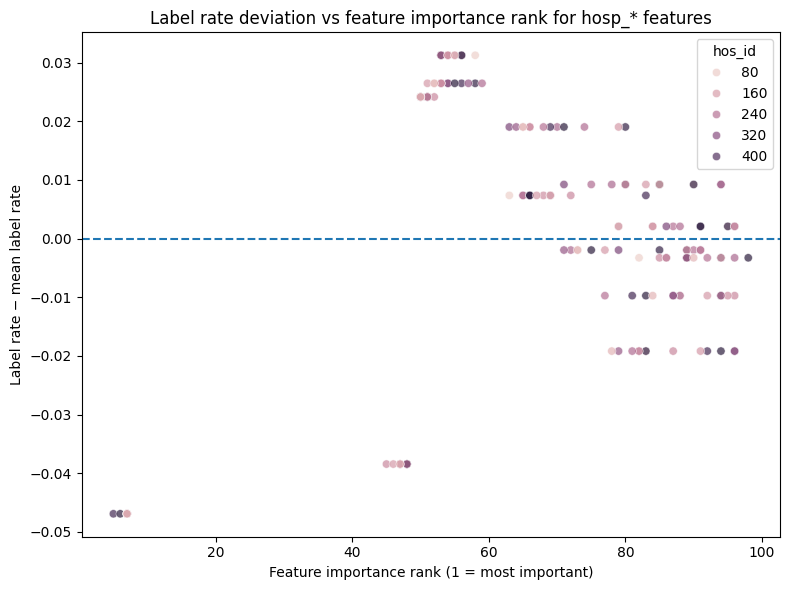

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# label_rates: pd.Series indexed by feature name, e.g. "hosp_101", "hosp_102", ...
# fi: DataFrame with columns:
#   ["hos_id", "repetition", "fold", "feature", "importance", "importance_norm"]

label_mean = label_rates.mean()

rows = []

for hos in fi["hos_id"].unique():
    fi_hos = fi[fi["hos_id"] == hos]

    # Aggregate importance over reps/folds for ALL features for this hospital
    agg = (
        fi_hos.groupby("feature")["importance_norm"]
              .mean()
              .sort_values(ascending=False)
              .reset_index()
    )
    # Rank: 1 = most important
    agg["rank"] = np.arange(1, len(agg) + 1)

    # Keep only hosp_* features, but keep their global rank
    hosp_rows = agg[agg["feature"].str.startswith("hosp_")].copy()
    if hosp_rows.empty:
        continue

    # Merge label rates (index of label_rates aligns with "feature")
    hosp_rows = hosp_rows.merge(
        label_rates.rename("label_rate"),
        left_on="feature",
        right_index=True,
        how="left"
    )

    # Drop any rows without a label_rate, just in case
    hosp_rows = hosp_rows.dropna(subset=["label_rate"])

    # Add hospital id and label-rate difference from global mean
    hosp_rows["hos_id"] = hos
    hosp_rows["label_rate_diff"] = hosp_rows["label_rate"] - label_mean

    rows.append(hosp_rows)

# Combine all hospitals
rank_label_df = pd.concat(rows, ignore_index=True)

# Scatter plot: rank vs (label_rate - mean_label_rate)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rank_label_df,
    x="rank",
    y="label_rate_diff",
    hue="hos_id",   # optional: comment out if you don't want per-hospital colors
    alpha=0.7
)
plt.axhline(0, linestyle="--")
plt.xlabel("Feature importance rank (1 = most important)")
plt.ylabel("Label rate − mean label rate")
plt.title("Label rate deviation vs feature importance rank for hosp_* features")
plt.tight_layout()
plt.show()


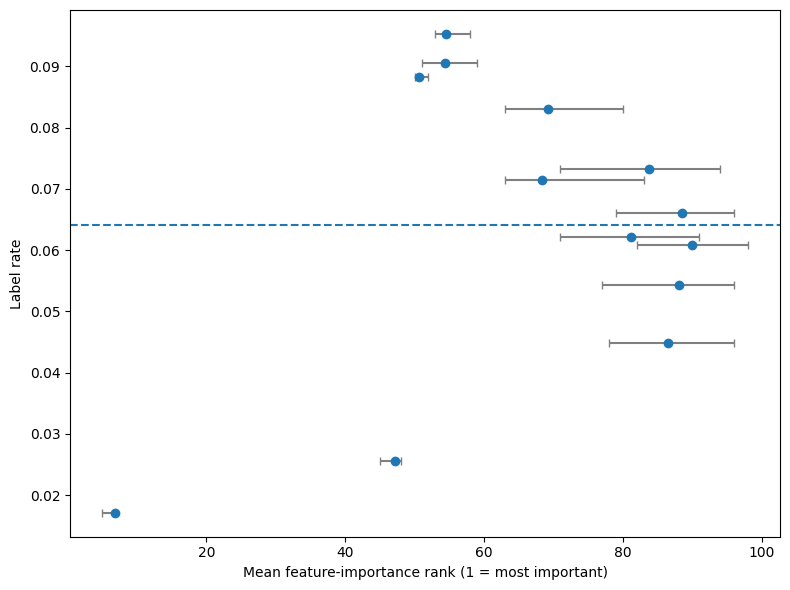

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# fi: DataFrame with ["hos_id", "repetition", "fold", "feature", "importance", "importance_norm"]
# label_rates: pd.Series, index aligned with "hosp_*" feature names

rank_rows = []

# 1. Compute ranks per test hospital (hos_id)
for hos in fi["hos_id"].unique():
    fi_hos = fi[fi["hos_id"] == hos]

    agg = (
        fi_hos.groupby("feature")["importance_norm"]
              .mean()
              .sort_values(ascending=False)
              .reset_index()
    )
    # rank 1 = most important
    agg["rank"] = np.arange(1, len(agg) + 1)
    agg["test_hos_id"] = hos

    rank_rows.append(agg[["feature", "test_hos_id", "rank"]])

rank_df = pd.concat(rank_rows, ignore_index=True)

# 2. Keep only hosp_* features that have label rates
rank_df = rank_df[rank_df["feature"].str.startswith("hosp_")].copy()
rank_df = rank_df[rank_df["feature"].isin(label_rates.index)]

# 3. Aggregate across test hospitals: mean, min, max rank per feature
summary = (
    rank_df.groupby("feature")["rank"]
           .agg(mean_rank="mean", min_rank="min", max_rank="max")
           .reset_index()
)

# 4. Attach label rates
summary = summary.merge(
    label_rates.rename("label_rate"),
    left_on="feature",
    right_index=True,
    how="left"
)
summary = summary.dropna(subset=["label_rate"])

# 5. Plot: each feature (hospital) as a dot with horizontal intervals
x = summary["mean_rank"].values
y = summary["label_rate"].values
xerr = np.vstack([
    summary["mean_rank"] - summary["min_rank"],
    summary["max_rank"] - summary["mean_rank"],
])

plt.figure(figsize=(8, 6))
plt.errorbar(
    x=x,
    y=y,
    xerr=xerr,
    fmt="o",
    ecolor="gray",
    capsize=3,
    linestyle="none",
)

# Optional: put most important (rank 1) on the left
# plt.gca().invert_xaxis()
plt.axhline(np.mean(label_rates), linestyle="--")

plt.xlabel("Mean feature-importance rank (1 = most important)")
plt.ylabel("Label rate")
# plt.title("Hospital feature rank vs label rate (hosp_* features)")
plt.tight_layout()
plt.show()


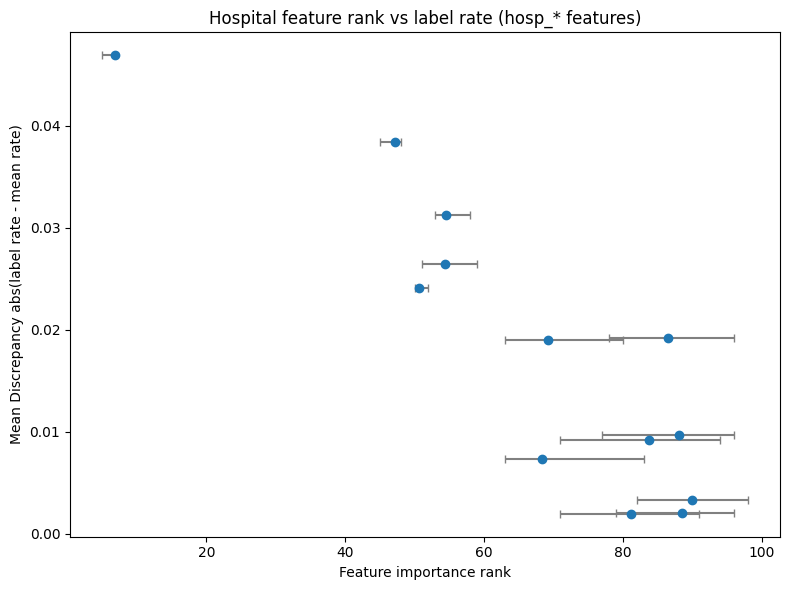

In [26]:
import numpy as np
import matplotlib.pyplot as plt

rank_rows = []

# 1. Compute ranks per test hospital (hos_id)
for hos in fi["hos_id"].unique():
    fi_hos = fi[fi["hos_id"] == hos]

    agg = (
        fi_hos.groupby("feature")["importance_norm"]
              .mean()
              .sort_values(ascending=False)
              .reset_index()
    )
    # rank 1 = most important
    agg["rank"] = np.arange(1, len(agg) + 1)
    agg["test_hos_id"] = hos

    rank_rows.append(agg[["feature", "test_hos_id", "rank"]])

rank_df = pd.concat(rank_rows, ignore_index=True)

# 2. Keep only hosp_* features that have label rates
rank_df = rank_df[rank_df["feature"].str.startswith("hosp_")].copy()
rank_df = rank_df[rank_df["feature"].isin(label_rates.index)]

# 3. Aggregate across test hospitals: mean, min, max rank per feature
summary = (
    rank_df.groupby("feature")["rank"]
           .agg(mean_rank="mean", min_rank="min", max_rank="max")
           .reset_index()
)

# 4. Attach label rates
summary = summary.merge(
    label_rates.rename("label_rate"),
    left_on="feature",
    right_index=True,
    how="left"
)
summary = summary.dropna(subset=["label_rate"])

# 5. Plot: each feature (hospital) as a dot with horizontal intervals
x = summary["mean_rank"].values
y = abs(summary["label_rate"].values - np.mean(label_rates))
xerr = np.vstack([
    summary["mean_rank"] - summary["min_rank"],
    summary["max_rank"] - summary["mean_rank"],
])

plt.figure(figsize=(8, 6))
plt.errorbar(
    x=x,
    y=y,
    xerr=xerr,
    fmt="o",
    ecolor="gray",
    capsize=3,
    linestyle="none",
)

# # Optional: put most important (rank 1) on the left
# # plt.gca().invert_xaxis()
# plt.axhline(np.mean(label_rates), linestyle="--")
plt.xlabel("Feature importance rank")
plt.ylabel("Mean Discrepancy abs(label rate - mean rate)")
plt.title("Hospital feature rank vs label rate (hosp_* features)")
plt.tight_layout()
plt.show()
